1. Load in the data. The target column should be considered as whether a patient will develop heart disease or not.

In [92]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")


In [3]:
df=pd.read_csv('heart.csv')
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


Explore the data. Notice all columns are numerical. Therefore separate the continuous from
the discrete features.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
df.shape

(303, 14)

In [7]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [8]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [9]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

It is always better to check the correlation between the features so that we can analyze that which feature is negatively correlated and which is positively correlated so, Let’s check the correlation between various features.

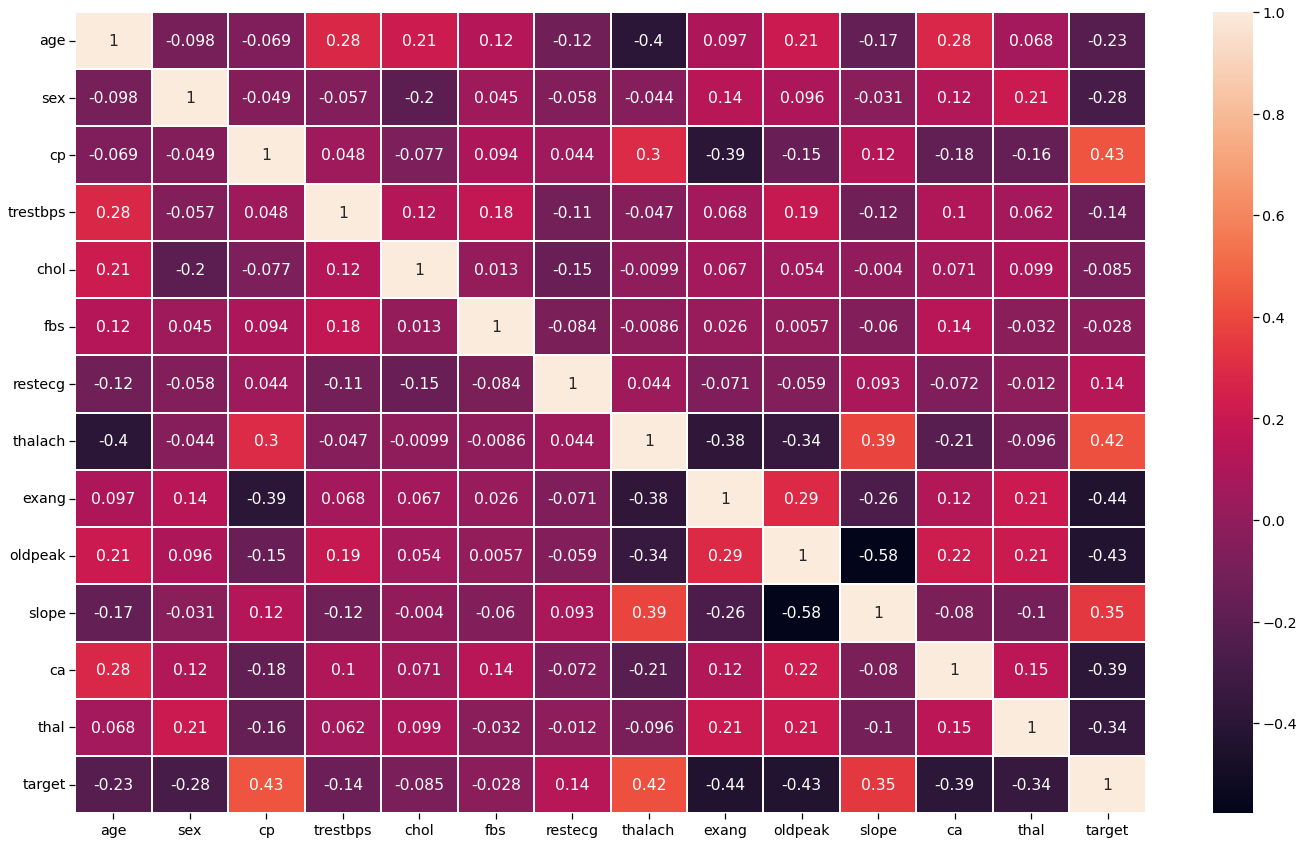

In [10]:
plt.figure(figsize=(20,12))
sns.set_context('notebook',font_scale = 1.3)
sns.heatmap(df.corr(),annot=True,linewidth =2)
plt.tight_layout()

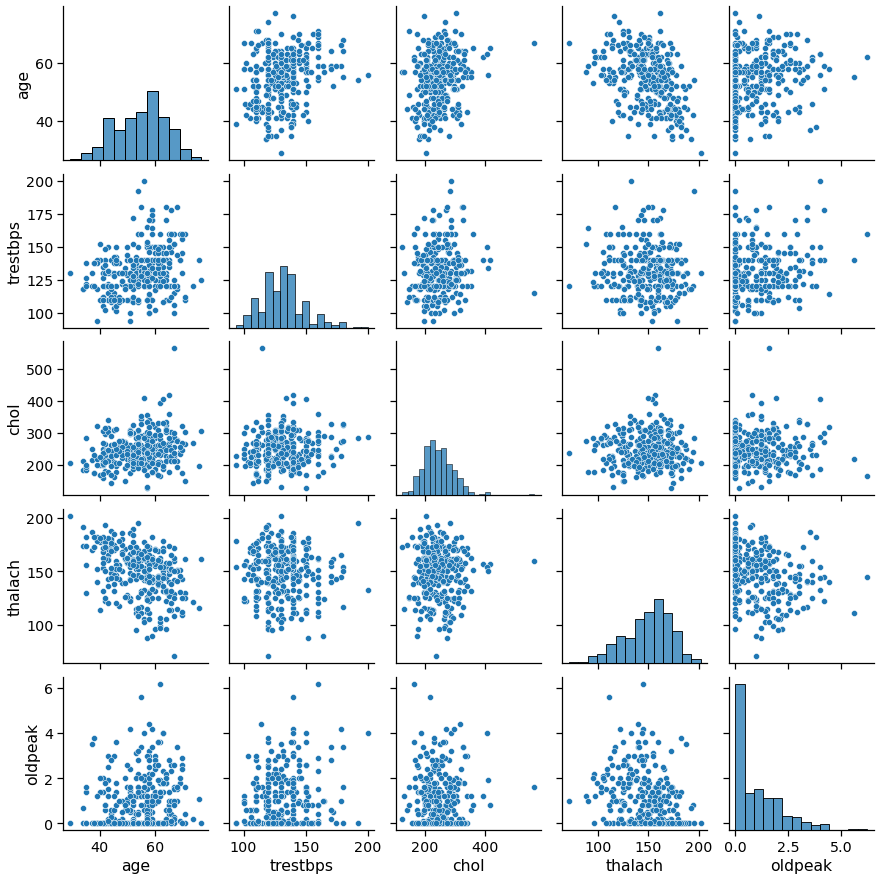

In [11]:
subData = df[['age','trestbps','chol','thalach','oldpeak']]
sns.pairplot(subData)

By far we have checked the correlation between the features but it is also a good practice to check the correlation of the target variable.

So, let’s do this!

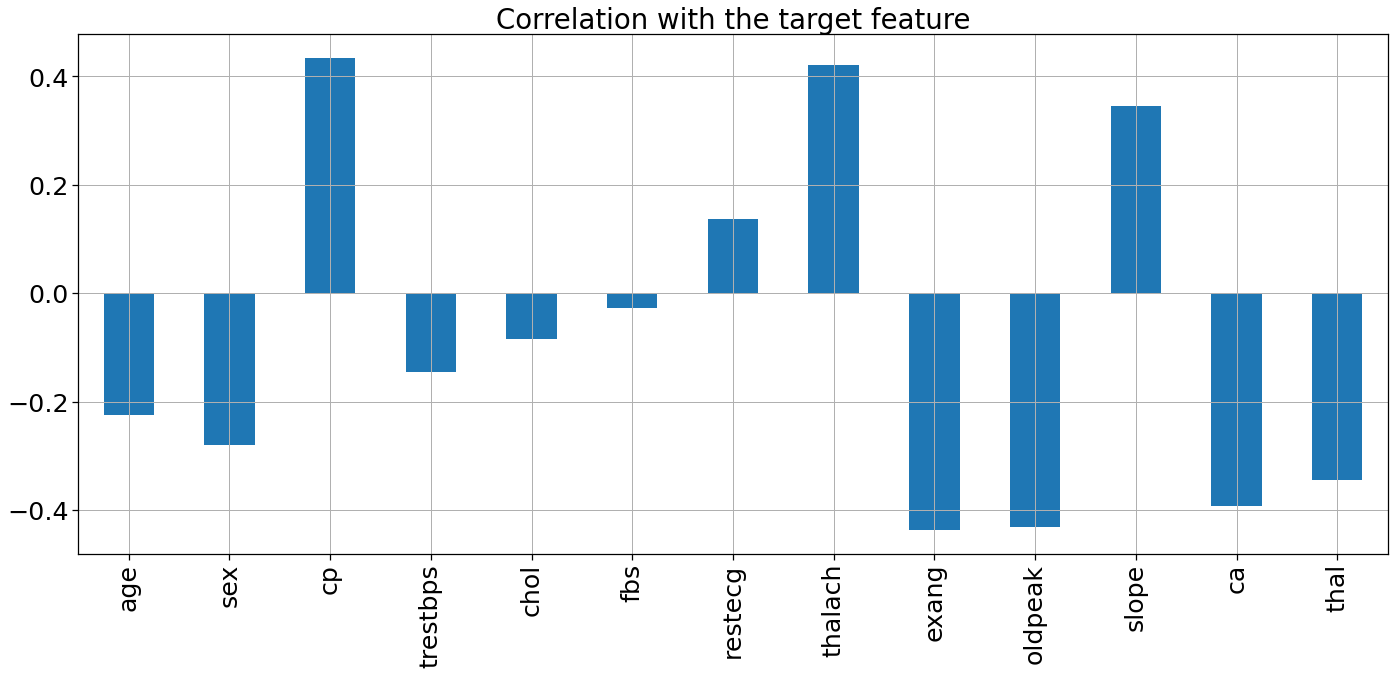

In [12]:
sns.set_context('notebook',font_scale = 2.3)
df.drop('target', axis=1).corrwith(df.target).plot(kind='bar', grid=True, figsize=(20, 10), 
                                                        title="Correlation with the target feature")
plt.tight_layout()

Inference: Insights from the above graph are:

Four feature( “cp”, “restecg”, “thalach”, “slope” ) are positively correlated with the target feature.
Other features are negatively correlated with the target feature.

Separating the continuous from the discrete features.

In [13]:
numerical_continuous = []
for column in df.columns:
    if df[column].dtypes != 'object':
        if df[column].nunique() >= 10:
            numerical_continuous.append(column)

numerical_continuous

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [14]:
numerical_discrete = []
for column in df.columns:
    if df[column].dtypes != 'object':
        if df[column].nunique() < 10:
            numerical_discrete.append(column)
numerical_discrete.remove('target')
numerical_discrete

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

Identify any presence of outliers in the continuous features and resolve them using the IQR
method.

<AxesSubplot:>

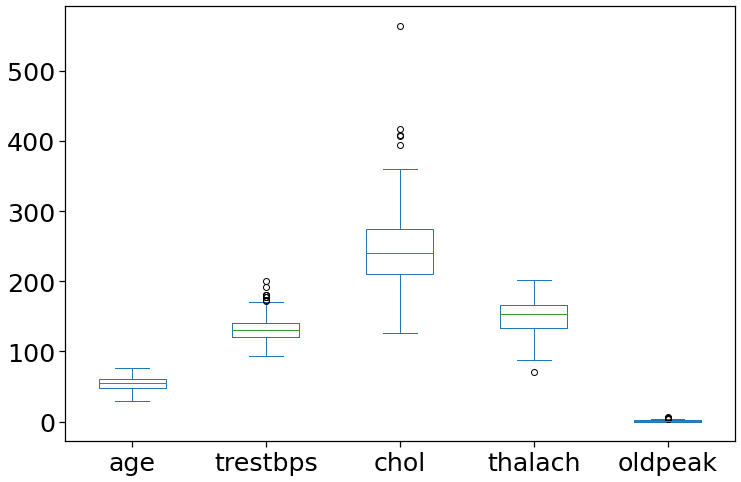

In [15]:
df[numerical_continuous].plot(kind = 'box', figsize = (12, 8))

In [16]:
Q1 = df[numerical_continuous].quantile(0.25)
Q3 = df[numerical_continuous].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

age         13.5
trestbps    20.0
chol        63.5
thalach     32.5
oldpeak      1.6
dtype: float64


As we now have the IQR scores, it’s time to get hold on outliers. The below code will give an output with cleaned dataset by removing the Outliers.

In [17]:
print("Old data set shape with Outliers ",df.shape)
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
print("New data set shape without Outliers ",df_out.shape)

Old data set shape with Outliers  (303, 14)
New data set shape without Outliers  (284, 14)


In [18]:
def remove_outlier_Hampel(df):
    med=df.median()
    List=abs(df-med)
    cond=List.median()*4.5
    good_list=List[~(List>cond)]
    return good_list

size of numerical continuous before outlier removal is 303
size of numerical continuous column after outlier removal is 303


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'age'),
  Text(1, 0, 'trestbps'),
  Text(2, 0, 'chol'),
  Text(3, 0, 'thalach'),
  Text(4, 0, 'oldpeak')])

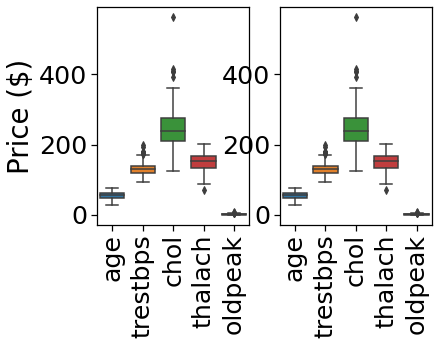

In [19]:
print("size of numerical continuous before outlier removal is",df[numerical_continuous].shape[0])
df_outlier_removed=remove_outlier_Hampel(df[numerical_continuous])
print("size of numerical continuous column after outlier removal is",df_outlier_removed.shape[0])
plt.subplot(1,2,1)
sns.boxplot(data=df[numerical_continuous])
plt.xticks(rotation=90)
plt.ylabel('Price ($)')
# Finding the index's of outlier items 
ind_diff=df.index.difference(df_outlier_removed.index)
# dropping all rows from the data frame which having outliers
for i in range(0, len(ind_diff),1):
    df.drop([ind_diff[i]],inplace=True)
plt.subplot(1,2,2)
sns.boxplot(data=df[numerical_continuous])
plt.xticks(rotation=90)

Binned the continuous column values apart from the column ‘oldpeak’.

In [20]:
numerical_continuous = []
for column in df_out.columns:
    if df_out[column].dtypes != 'object':
        if df_out[column].nunique() >= 10:
            numerical_continuous.append(column)

numerical_continuous.remove('oldpeak')            
numerical_continuous

['age', 'trestbps', 'chol', 'thalach']

In [21]:
df['age_group'] = pd.qcut(df['age'], 4)
df['trestbps_group'] = pd.qcut(df['trestbps'], 4)
df['chol_group'] = pd.qcut(df['chol'], 4)
df['thalach_group'] = pd.qcut(df['thalach'], 4)

df.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_group,trestbps_group,chol_group,thalach_group
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,"(61.0, 77.0]","(140.0, 200.0]","(211.0, 240.0]","(133.5, 153.0]"
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,"(28.999, 47.5]","(120.0, 130.0]","(240.0, 274.5]","(166.0, 202.0]"


In [22]:
df['age_group'] = pd.qcut(df['age'], [0,0.25,0.5,0.75,1], labels=['young','middle_aged', 'seniors','old'])
df['trestbps_group'] = pd.qcut(df['trestbps'], [0,0.25,0.5,0.75,1], labels=['low','normal', 'borderline','high'])
df['chol_group'] = pd.qcut(df['chol'], [0,0.25,0.5,0.75,1], labels=['low','normal', 'borderline','high'])
df['thalach_group'] = pd.qcut(df['thalach'], [0,0.25,0.5,0.75,1], labels=['low','normal', 'borderline','high'])
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_group,trestbps_group,chol_group,thalach_group
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,old,high,normal,normal
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,young,normal,borderline,high
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,young,normal,low,high
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,seniors,low,normal,high
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,seniors,low,high,borderline


Separate the features from the labels and use the most appropriate feature selection technique(s)

In [23]:
# separating the data and labels
X = df.drop(columns = ['target', 'age_group', 'trestbps_group', 'chol_group', 'thalach_group'], axis=1)
Y = df['target']

In [24]:
# converting 'oldpeak' from float to int
df = df.astype({"oldpeak":'int'})

In [25]:
X.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2


In [26]:
Y.head(2)

0    1
1    1
Name: target, dtype: int64

In [27]:
# Setup random seed
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
np.random.seed(42)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2,  random_state=1)

In [28]:
print(X.shape, X_train.shape, X_test.shape)

(303, 13) (242, 13) (61, 13)


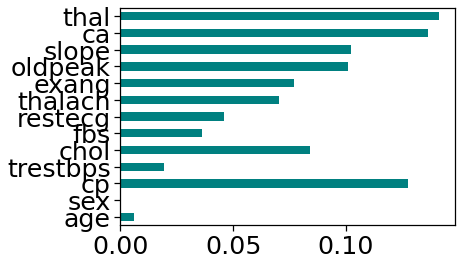

In [29]:
# Filter method
# Information Gain

from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline

importances = mutual_info_classif(X, Y)
feat_importances = pd.Series(importances, df.columns[0:len(df.columns)-5])
feat_importances.plot(kind='barh', color = 'teal')
plt.show()

<AxesSubplot:>

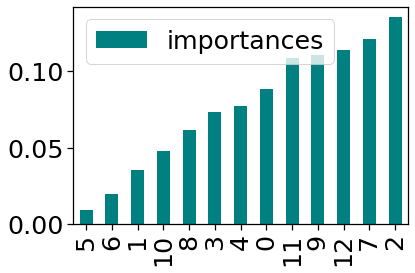

In [30]:
model=RandomForestClassifier(n_estimators=340)
model.fit(X, Y)

importances = model.feature_importances_

final_df =pd.DataFrame({'Features':pd.DataFrame(X).columns,'importances':importances})
final_df.set_index('importances')

final_df = final_df.sort_values ('importances')

final_df.plot.bar(color = 'teal')

<BarContainer object of 13 artists>

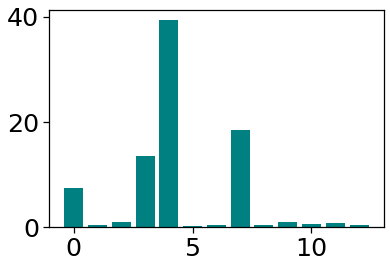

In [31]:
# calculate MEAN ABSOLUTE DIFFERENCE (MAD)

mean_abs_diff = np.sum(np.abs(X -np.mean(X, axis =0)), axis =0)/X.shape[0]

#plot the barchart
plt.bar(np.arange(X.shape[1]), mean_abs_diff, color ='teal')

Slice the data and scale the features.

In [32]:
cols = ['age', 'trestbps', 'chol', 'thalach']
df[cols].head(2)

,age,trestbps,chol,thalach
0,63,145,233,150
1,37,130,250,187


In [33]:
df.loc[0:3, ['age', 'trestbps', 'chol', 'thalach']]

,age,trestbps,chol,thalach
0,63,145,233,150
1,37,130,250,187
2,41,130,204,172
3,56,120,236,178


In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [35]:
scaled_data = df[cols]

print('Mean:', scaled_data[cols].mean())
print('Standard Deviation:', scaled_data[cols].std())

Mean: age          54.366337
trestbps    131.623762
chol        246.264026
thalach     149.646865
dtype: float64
Standard Deviation: age          9.082101
trestbps    17.538143
chol        51.830751
thalach     22.905161
dtype: float64


Using at least 4 classification methods, identify the best machine learning model using their training and testing accuracy scores.Using at least 4 classification methods, identify the best machine learning model using their training and testing accuracy scores.

In [47]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

Comparing the accuracy of Logistic Regression, K-NN (k-Nearest Neighbours), Decision Trees and Random Forest.compare the accuracy of Logistic Regression, K-NN (k-Nearest Neighbours), Decision Trees and Random Forest.

In [48]:
# Model 1: Logistic Regression
from sklearn.metrics import classification_report 
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(random_state=1) # get instance of model
model1.fit(X_train, Y_train) # Train/Fit model 

Y_pred1 = model1.predict(X_test) # get y predictions
print(classification_report(Y_test,Y_pred1)) # output accuracy


              precision    recall  f1-score   support

           0       0.80      0.78      0.79        41
           1       0.82      0.84      0.83        50

    accuracy                           0.81        91
   macro avg       0.81      0.81      0.81        91
weighted avg       0.81      0.81      0.81        91



In [38]:
  # Model 2: K-NN (K-Nearest Neighbors)

from sklearn.neighbors import KNeighborsClassifier
model2 = KNeighborsClassifier() # get instance of model
model2.fit(X_train, Y_train) # Train/Fit model 

Y_pred2 = model2.predict(X_test) # get y predictions
print(classification_report(Y_test, Y_pred2)) # output accuracy

              precision    recall  f1-score   support

           0       0.63      0.59      0.61        41
           1       0.68      0.72      0.70        50

    accuracy                           0.66        91
   macro avg       0.66      0.65      0.65        91
weighted avg       0.66      0.66      0.66        91



In [39]:
# Model 3: Decision Trees

from sklearn.tree import DecisionTreeClassifier

model3 = DecisionTreeClassifier(random_state=1) # get instance of model
model3.fit(X_train, Y_train) # Train/Fit model 

Y_pred3 = model3.predict(X_test) # get y predictions
print(classification_report(Y_test, Y_pred3)) # output accuracy

              precision    recall  f1-score   support

           0       0.67      0.78      0.72        41
           1       0.79      0.68      0.73        50

    accuracy                           0.73        91
   macro avg       0.73      0.73      0.73        91
weighted avg       0.73      0.73      0.73        91



In [40]:
# Model 4: Random Forest 

from sklearn.metrics import classification_report 
from sklearn.ensemble import RandomForestClassifier

model4 = RandomForestClassifier(random_state=1)# get instance of model
model4.fit(X_train, Y_train) # Train/Fit model 

Y_pred4 = model4.predict(X_test) # get y predictions
print(classification_report(Y_test, Y_pred4)) # output accuracy

              precision    recall  f1-score   support

           0       0.80      0.78      0.79        41
           1       0.82      0.84      0.83        50

    accuracy                           0.81        91
   macro avg       0.81      0.81      0.81        91
weighted avg       0.81      0.81      0.81        91



Random Forest algorithm yields the highest accuracy, 85%. Any accuracy above 70% is considered good. Thus, 79% is the ideal accuracy!

9.  Hyper parameter tune the best model using grid search to identify the best performing model.
10.  Redefine the model instance based on the grid search results, train it and evaluate it using:

a. A classification report.

b. A visual representation and well labelled confusion matrix.

c. AUC score. (Explain the score in a markdown cell.)

d. ROC curve.

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, Y_train, X_test, Y, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(Y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(Y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(Y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(Y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(Y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(Y_test, pred)}\n")

In [54]:
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, Y_train)

print_score(lr_clf, X_train, Y_train, X_test, Y_test, train=True)
print_score(lr_clf, X_train, Y_train, X_test, Y_test, train=False)

Train Result:
Accuracy Score: 87.26%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.888889    0.860656  0.872642    0.874772      0.873574
recall      0.824742    0.913043  0.872642    0.868893      0.872642
f1-score    0.855615    0.886076  0.872642    0.870845      0.872139
support    97.000000  115.000000  0.872642  212.000000    212.000000
_______________________________________________
Confusion Matrix: 
 [[ 80  17]
 [ 10 105]]

Test Result:
Accuracy Score: 81.32%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.800000   0.823529  0.813187   0.811765      0.812928
recall      0.780488   0.840000  0.813187   0.810244      0.813187
f1-score    0.790123   0.831683  0.813187   0.810903      0.812958
support    41.000000  50.000000  0.813187  91.000000     91.000000
_____________

In [55]:
test_score = accuracy_score(Y_test, lr_clf.predict(X_test)) * 100
train_score = accuracy_score(Y_train, lr_clf.predict(X_train)) * 100

results_df = pd.DataFrame(data=[["Logistic Regression", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,87.264151,81.318681


 K-nearest neighbors

In [56]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, Y_train)

print_score(knn_clf, X_train, Y_train, X_test, Y_test, train=True)
print_score(knn_clf, X_train, Y_train, X_test, Y_test, train=False)

Train Result:
Accuracy Score: 76.89%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.779070    0.761905  0.768868    0.770487      0.769759
recall      0.690722    0.834783  0.768868    0.762752      0.768868
f1-score    0.732240    0.796680  0.768868    0.764460      0.767196
support    97.000000  115.000000  0.768868  212.000000    212.000000
_______________________________________________
Confusion Matrix: 
 [[67 30]
 [19 96]]

Test Result:
Accuracy Score: 65.93%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.631579   0.679245  0.659341   0.655412      0.657769
recall      0.585366   0.720000  0.659341   0.652683      0.659341
f1-score    0.607595   0.699029  0.659341   0.653312      0.657834
support    41.000000  50.000000  0.659341  91.000000     91.000000
_________________

In [89]:
test_score = accuracy_score(Y_test, knn_clf.predict(X_test)) * 100
train_score = accuracy_score(Y_train, knn_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["K-nearest neighbors", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])

results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,87.264151,81.318681
1,Decision Tree Classifier,100.000000,73.626374
2,Random Forest Classifier,100.000000,81.318681
3,K-nearest neighbors,54.245283,54.945055


Decision Tree Classifier

In [58]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, Y_train)

print_score(tree_clf, X_train, Y_train, X_test, Y_test, train=True)
print_score(tree_clf, X_train, Y_train, X_test, Y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              0      1  accuracy  macro avg  weighted avg
precision   1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0       1.0        1.0           1.0
support    97.0  115.0       1.0      212.0         212.0
_______________________________________________
Confusion Matrix: 
 [[ 97   0]
 [  0 115]]

Test Result:
Accuracy Score: 73.63%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.680851   0.795455  0.736264   0.738153      0.743820
recall      0.780488   0.700000  0.736264   0.740244      0.736264
f1-score    0.727273   0.744681  0.736264   0.735977      0.736838
support    41.000000  50.000000  0.736264  91.000000     91.000000
_______________________________________________
Confusion Matrix: 


In [59]:
test_score = accuracy_score(Y_test, tree_clf.predict(X_test)) * 100
train_score = accuracy_score(Y_train, tree_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Decision Tree Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,87.264151,81.318681
1,Decision Tree Classifier,100.000000,73.626374


Random ForestRandom Forest

In [60]:
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_clf.fit(X_train, Y_train)

print_score(rf_clf, X_train, Y_train, X_test, Y_test, train=True)
print_score(rf_clf, X_train, Y_train, X_test, Y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              0      1  accuracy  macro avg  weighted avg
precision   1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0       1.0        1.0           1.0
support    97.0  115.0       1.0      212.0         212.0
_______________________________________________
Confusion Matrix: 
 [[ 97   0]
 [  0 115]]

Test Result:
Accuracy Score: 81.32%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.800000   0.823529  0.813187   0.811765      0.812928
recall      0.780488   0.840000  0.813187   0.810244      0.813187
f1-score    0.790123   0.831683  0.813187   0.810903      0.812958
support    41.000000  50.000000  0.813187  91.000000     91.000000
_______________________________________________
Confusion Matrix: 


In [61]:
test_score = accuracy_score(Y_test, rf_clf.predict(X_test)) * 100
train_score = accuracy_score(Y_train, rf_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Random Forest Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df


,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,87.264151,81.318681
1,Decision Tree Classifier,100.000000,73.626374
2,Random Forest Classifier,100.000000,81.318681


Models Hyperparameter Tuning

1. Logistic Regression Hyperparameter Tuning

In [62]:
from sklearn.model_selection import GridSearchCV


params = {"C": np.logspace(-4, 4, 20),
          "solver": ["liblinear"]}

lr_clf = LogisticRegression()

lr_cv = GridSearchCV(lr_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
lr_cv.fit(X_train, Y_train)
best_params = lr_cv.best_params_
print(f"Best parameters: {best_params}")
lr_clf = LogisticRegression(**best_params)

lr_clf.fit(X_train, Y_train)

print_score(lr_clf, X_train, Y_train, X_test, Y_test, train=True)
print_score(lr_clf, X_train, Y_train, X_test, Y_test, train=False)          

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 0.08858667904100823, 'solver': 'liblinear'}
Train Result:
Accuracy Score: 84.91%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.901235    0.816794  0.849057    0.859014      0.855429
recall      0.752577    0.930435  0.849057    0.841506      0.849057
f1-score    0.820225    0.869919  0.849057    0.845072      0.847181
support    97.000000  115.000000  0.849057  212.000000    212.000000
_______________________________________________
Confusion Matrix: 
 [[ 73  24]
 [  8 107]]

Test Result:
Accuracy Score: 84.62%
_______________________________________________
CLASSIFICATION REPORT:
                   0      1  accuracy  macro avg  weighted avg
precision   0.829268   0.86  0.846154   0.844634      0.846154
recall      0.829268   0.86  0.846154   0.844634      0.846154
f1-score    0.829268   0.86  0

In [63]:
test_score = accuracy_score(Y_test, lr_clf.predict(X_test)) * 100
train_score = accuracy_score(Y_train, lr_clf.predict(X_train)) * 100

tuning_results_df = pd.DataFrame(data=[["Tuned Logistic Regression", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
tuning_results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Tuned Logistic Regression,84.90566,84.615385


2. K-nearest neighbors Hyperparameter Tuning

In [64]:
train_score = []
test_score = []
neighbors = range(1, 30)

for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, Y_train)
    train_score.append(accuracy_score(Y_train, model.predict(X_train)))
#     test_score.append(accuracy_score(Y_test, model.predict(X_test)))

Maximum KNN score on the test data: 100.00%


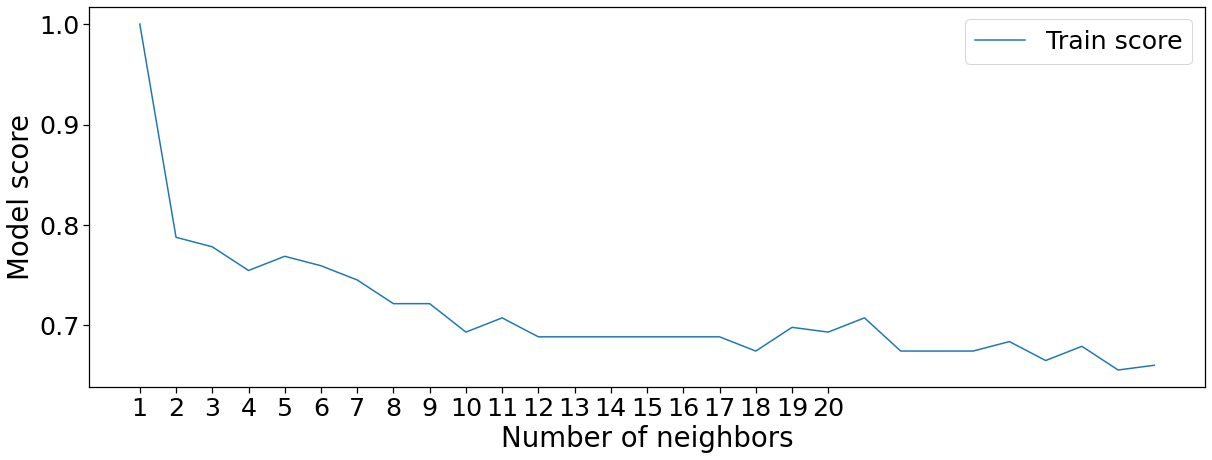

In [65]:
plt.figure(figsize=(20, 7))

plt.plot(neighbors, train_score, label="Train score")
# plt.plot(neighbors, test_score, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(train_score)*100:.2f}%")

In [66]:
knn_clf = KNeighborsClassifier(n_neighbors=27)
knn_clf.fit(X_train, Y_train)

print_score(knn_clf, X_train, Y_train, X_test, Y_test, train=True)
print_score(knn_clf, X_train, Y_train, X_test, Y_test, train=False)

Train Result:
Accuracy Score: 67.92%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.670588    0.685039  0.679245    0.677814      0.678427
recall      0.587629    0.756522  0.679245    0.672075      0.679245
f1-score    0.626374    0.719008  0.679245    0.672691      0.676624
support    97.000000  115.000000  0.679245  212.000000    212.000000
_______________________________________________
Confusion Matrix: 
 [[57 40]
 [28 87]]

Test Result:
Accuracy Score: 67.03%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.641026   0.692308   0.67033   0.666667      0.669203
recall      0.609756   0.720000   0.67033   0.664878      0.670330
f1-score    0.625000   0.705882   0.67033   0.665441      0.669441
support    41.000000  50.000000   0.67033  91.000000     91.000000
_________________

In [67]:
test_score = accuracy_score(Y_test, knn_clf.predict(X_test)) * 100
train_score = accuracy_score(Y_train, knn_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Tuned K-nearest neighbors", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
tuning_results_df = tuning_results_df.append(results_df_2, ignore_index=True)
tuning_results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Tuned Logistic Regression,84.905660,84.615385
1,Tuned K-nearest neighbors,67.924528,67.032967


 Decision Tree Classifier Hyperparameter Tuning

In [68]:
params = {"criterion":("gini", "entropy"), 
          "splitter":("best", "random"), 
          "max_depth":(list(range(1, 20))), 
          "min_samples_split":[2, 3, 4], 
          "min_samples_leaf":list(range(1, 20))}

tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(X_train, Y_train)
best_params = tree_cv.best_params_
print(f'Best_params: {best_params}')

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, Y_train)

print_score(tree_clf, X_train, Y_train, X_test, Y_test, train=True)
print_score(tree_clf, X_train, Y_train, X_test, Y_test, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best_params: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 2, 'splitter': 'best'}
Train Result:
Accuracy Score: 86.79%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.879121    0.859504  0.867925    0.869313      0.868480
recall      0.824742    0.904348  0.867925    0.864545      0.867925
f1-score    0.851064    0.881356  0.867925    0.866210      0.867496
support    97.000000  115.000000  0.867925  212.000000    212.000000
_______________________________________________
Confusion Matrix: 
 [[ 80  17]
 [ 11 104]]

Test Result:
Accuracy Score: 76.92%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.727273   0.808511  0.769231   0.767892      0.771909
recall      0.780488   0.76

In [69]:
test_score = accuracy_score(Y_test, tree_clf.predict(X_test)) * 100
train_score = accuracy_score(Y_train, tree_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Tuned Decision Tree Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
tuning_results_df = tuning_results_df.append(results_df_2, ignore_index=True)
tuning_results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Tuned Logistic Regression,84.905660,84.615385
1,Tuned K-nearest neighbors,67.924528,67.032967
2,Tuned Decision Tree Classifier,86.792453,76.923077



5. Random Forest Classifier Hyperparameter Tuning

In [70]:
n_estimators = [500, 900, 1100, 1500]
max_features = ['auto', 'sqrt']
max_depth = [2, 3, 5, 10, 15, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

params_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth': max_depth, 
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf}

rf_clf = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(rf_clf, params_grid, scoring="accuracy", cv=3, verbose=1, n_jobs=-1)
rf_cv.fit(X_train, Y_train)
best_params = rf_cv.best_params_
print(f"Best parameters: {best_params}")
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, Y_train)

print_score(rf_clf, X_train, Y_train, X_test, Y_test, train=True)
print_score(rf_clf, X_train, Y_train, X_test, Y_test, train=False)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 900}
Train Result:
Accuracy Score: 87.74%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.908046    0.856000  0.877358    0.882023      0.879813
recall      0.814433    0.930435  0.877358    0.872434      0.877358
f1-score    0.858696    0.891667  0.877358    0.875181      0.876581
support    97.000000  115.000000  0.877358  212.000000    212.000000
_______________________________________________
Confusion Matrix: 
 [[ 79  18]
 [  8 107]]

Test Result:
Accuracy Score: 84.62%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.864865   0.833333  0.846154   0.849099      0.847540
recall      0.780488   0

In [71]:
test_score = accuracy_score(Y_test, rf_clf.predict(X_test)) * 100
train_score = accuracy_score(Y_train, rf_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Tuned Random Forest Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
tuning_results_df = tuning_results_df.append(results_df_2, ignore_index=True)
tuning_results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Tuned Logistic Regression,84.905660,84.615385
1,Tuned K-nearest neighbors,67.924528,67.032967
2,Tuned Decision Tree Classifier,86.792453,76.923077
3,Tuned Random Forest Classifier,87.735849,84.615385


In [72]:
scaler =preprocessing.RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

AUC score.
ROC curve.

In [73]:
Accuracies= {} # make dictionry to save all accuracies models

# define model
lg = LogisticRegression()

# parameters
parameters=[{'penalty':['l1','l2'],'C':[0.1,0.4,0.5],'random_state':[0]}]

#define search
search = GridSearchCV(lg, parameters, scoring='accuracy', n_jobs=-1, )

# execute search
result = search.fit(X_train, Y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8441860465116278
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'random_state': 0}


In [76]:
# make function to draw the plot ROC to easly
def plot_roc_(fpr,tpr,roc_auc):
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr,tpr, color='red',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()# make function to draw the plot ROC to easly


Logistic Regression Model

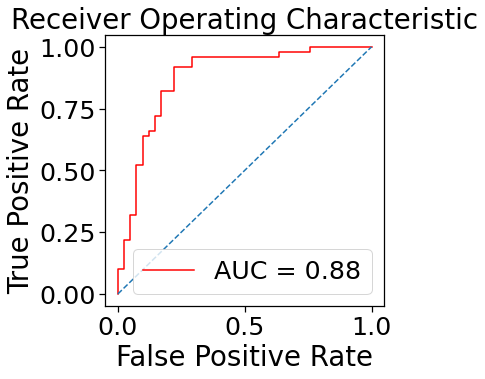

In [77]:

lr=LogisticRegression(C=0.1,penalty='l2',random_state=0)
lr.fit(X_train,Y_train)

Y_pred=lr.predict(X_test)
Y_proba=lr.predict_proba(X_test)

#Sensitivity= TP / TP + FN
#Specificity= TN / TN + FP
fpr, tpr, thresholds = roc_curve(Y_test,Y_proba[:,1])
roc_auc = auc(fpr, tpr)
plot_roc_(fpr,tpr,roc_auc)

Accuracy: 81.32%
Logistic TRAIN score with  0.8632075471698113
Logistic TEST score with  0.8131868131868132

[[32  9]
 [ 8 42]]


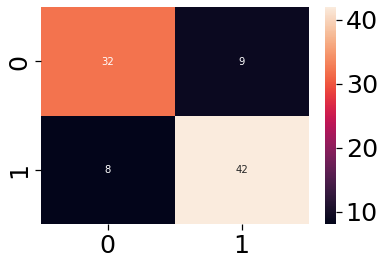

In [78]:
acc = accuracy_score(Y_test, Y_pred)*100
Accuracies['Logistic Regression'] = acc
print("Accuracy: {:.2f}%".format(acc))
print("Logistic TRAIN score with ",format(lr.score(X_train, Y_train)))
print("Logistic TEST score with ",format(lr.score(X_test, Y_test)))
print()
co=confusion_matrix(Y_test,Y_pred)
print(co)
sns.heatmap(co,annot=True)
plt.show()

KNN Model

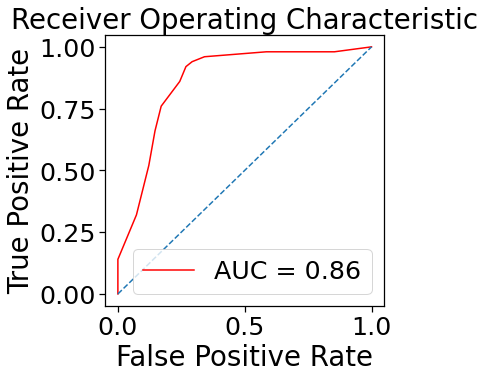

In [79]:
knn=KNeighborsClassifier(n_jobs=2, n_neighbors=11)
knn.fit(X_train,Y_train)

y_pred=knn.predict(X_test)
knn=KNeighborsClassifier(n_jobs=2, n_neighbors=11)
knn.fit(X_train,Y_train)

Y_pred=knn.predict(X_test)

Y_proba=knn.predict_proba(X_test)
#Sensitivity= TP / TP + FN
#Specificity= TN / TN + FP
fpr, tpr, thresholds = roc_curve(Y_test,Y_proba[:,1])
roc_auc = auc(fpr, tpr)
plot_roc_(fpr,tpr,roc_auc)

Accuracy: 81.32%
KNN TRAIN score with  0.8301886792452831
KNN TEST score with  0.8131868131868132

[[31 10]
 [ 7 43]]


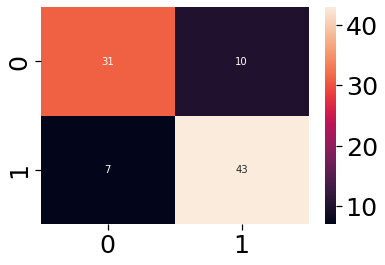

In [80]:
acc = accuracy_score(Y_test, Y_pred)*100
Accuracies['KNN'] = acc
print("Accuracy: {:.2f}%".format(acc))
print("KNN TRAIN score with ",format(knn.score(X_train, Y_train)))
print("KNN TEST score with ",format(knn.score(X_test, Y_test)))
print()

co=confusion_matrix(Y_test,Y_pred)
print(co)
sns.heatmap(co,annot=True)
plt.show()

Decision Tree Model

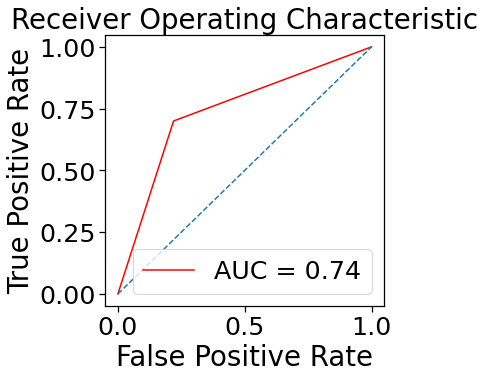

In [81]:
DT=DecisionTreeClassifier(random_state=42)
DT.fit(X_train,Y_train)

Y_pred=DT.predict(X_test)
Y_proba=DT.predict_proba(X_test)

#Sensitivity= TP / TP + FN
#Specificity= TN / TN + FP
fpr, tpr, thresholds = roc_curve(Y_test,Y_proba[:,1])
roc_auc = auc(fpr, tpr)
plot_roc_(fpr,tpr,roc_auc)

Accuracy: 73.63%
Decision Tree TRAIN score with  1.0
Decision Tree TEST score with  0.7362637362637363

[[32  9]
 [15 35]]


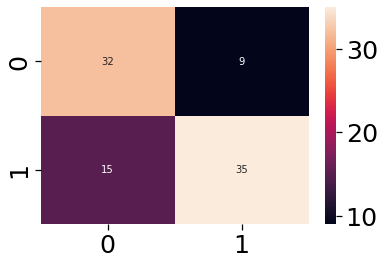

In [82]:
acc = accuracy_score(Y_test, Y_pred)*100
Accuracies['DT'] = acc
print("Accuracy: {:.2f}%".format(acc))
print("Decision Tree TRAIN score with ",format(DT.score(X_train, Y_train)))
print("Decision Tree TEST score with ",format(DT.score(X_test, Y_test)))
print()

co=confusion_matrix(Y_test,Y_pred)
print(co)
sns.heatmap(co,annot=True)
plt.show()

RANDOM FOREST

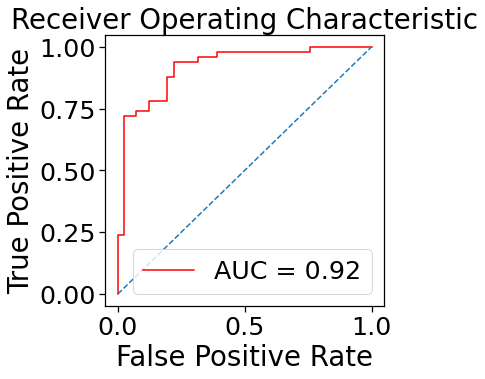

In [83]:
RF=RandomForestClassifier(max_depth=5, min_samples_split=2, n_estimators=11, random_state =3)
RF.fit(X_train,Y_train)

Y_pred=RF.predict(X_test)
Y_proba=RF.predict_proba(X_test)

#Sensitivity= TP / TP + FN
#Specificity= TN / TN + FP
fpr, tpr, thresholds = roc_curve(Y_test,Y_proba[:,1])
roc_auc = auc(fpr, tpr)
plot_roc_(fpr,tpr,roc_auc)

Accuracy: 80.22%
Random Forest TRAIN score with  0.9339622641509434
Random Forest TEST score with  0.8021978021978022

[[33  8]
 [10 40]]


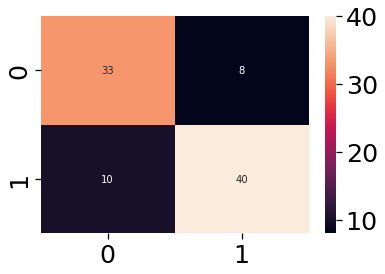

In [84]:
acc = accuracy_score(Y_test, Y_pred)*100
Accuracies['RF'] = acc
print("Accuracy: {:.2f}%".format(acc))
print("Random Forest TRAIN score with ",format(RF.score(X_train, Y_train)))
print("Random Forest TEST score with ",format(RF.score(X_test, Y_test)))
print()

co=confusion_matrix(Y_test,Y_pred)
print(co)
sns.heatmap(co,annot=True)
plt.show()

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.
The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.
Although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

    0.90 - 1.00 = excellent
    0.80 - 0.90 = good
    0.70 - 0.80 = fair
    0.60 - 0.70 = poor
    0.50 - 0.60 = fail
    
  According to results obtained in Receiving Operating Characteristics above with results listed below;
  
  Logistic regression = 0.88
  KNeighborsClassifiers = 0.86
  Decision Tree Classifiers = 0.74
  Randaom Forest Classifiers = 0.92
  
 Based on the above listed results, Random Forest classifier lies within the range of Excellent which concludes why it will be ideal given the nature of the data.


In [96]:
import joblib
import pickle

Save the model as ‘classification_model’

In [107]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)

filename = "Completed_model.joblib"
joblib.dump(model, filename)

['Completed_model.joblib']

In [106]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, Y_test)
print(result)

0.8131868131868132
